# Predicting Aberrations in The Hippo Signaling Pathway

## To do this, we will use Hetnets to query "Signaling by Hippo"

The query is built in the [Cypher Language](https://neo4j.com/developer/cypher-query-language/) and draws data from [Hetionet](https://neo4j.het.io/browser/)

### How Cognoma could help with Hippo signaling

The Hippo pathway is a highly conserved signaling cascade that controls organ size, cell growth, and cell death ([Zhao et al. 2010](http://doi.org/10.1101/gad.1909210)). It is one of the mechanisms that influences size diversity across eukaryotes; including different sizes across dog breeds ([Dong et al. 2007](http://doi.org/10.1016/j.cell.2007.07.019), [Crickmore and Mann 2008](http://doi.org/10.1002/bies.20806)). Recently, Hippo signaling has also been shown to be important for tumorigenesis, but there are shockingly few recurrent mutations of single genes within the pathway across tissues ([Harvey et al 2013](http://doi.org/10.1038/nrc3458)). Therefore, leveraging cancers from multiple tissues and combining genes associated with the same pathway could aid in the detection of a Hippo signaling specific gene expression signature. Cognoma is situated well to quickly query the list of all pathway associated genes, build a machine learning classifier to detect aberrant pathway activity, and output tissue and gene specific performance.

In [1]:
import os
import urllib
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from statsmodels.robust.scale import mad

In [2]:
from neo4j.v1 import GraphDatabase

In [3]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Specify model configuration - Generate genelist

In [4]:
names = ('label', 'rel_type', 'node_id')
query_params = [
    ('Pathway', 'PARTICIPATES_GpPW', 'PC7_7459'),             # "Signaling by Hippo" - Reactome
    ('BiologicalProcess', 'PARTICIPATES_GpBP', 'GO:0035329'), # "hippo signaling" - Gene Ontology
    ('BiologicalProcess', 'PARTICIPATES_GpBP', 'GO:0035330')  # "regulation of hippo signaling" - Gene Ontology
]

param_list = [dict(zip(names, qp)) for qp in query_params]

In [5]:
query = '''
MATCH (node)-[rel]-(gene)
WHERE node.identifier = {node_id}
  AND {label} in labels(node)
  AND {rel_type} = type(rel)
RETURN
  gene.identifier as entrez_gene_id,
  gene.name as gene_symbol
ORDER BY gene_symbol
'''

In [6]:
driver = GraphDatabase.driver("bolt://neo4j.het.io")
full_results_df = pd.DataFrame()
with driver.session() as session:
    for parameters in param_list:
        result = session.run(query, parameters)
        result_df = pd.DataFrame((x.values() for x in result), columns=result.keys())
        full_results_df = full_results_df.append(result_df, ignore_index=True)

classifier_genes_df = full_results_df.drop_duplicates().sort_values('gene_symbol').reset_index(drop=True)
classifier_genes_df['entrez_gene_id'] = classifier_genes_df['entrez_gene_id'].astype('str')

In [7]:
# Perform 5 fold cross validation
folds = 5

In [8]:
# Here are the genes that participate in the Hippo signaling pathway
classifier_genes_df

,entrez_gene_id,gene_symbol
0,84962,AJUBA
1,154796,AMOT
2,154810,AMOTL1
3,51421,AMOTL2
4,836,CASP3
5,8642,DCHS1
6,1856,DVL2
7,79633,FAT4
8,9113,LATS1
9,26524,LATS2


## Load Data

In [9]:
%%time
path = os.path.join('download', 'expression-matrix.tsv.bz2')
X = pd.read_table(path, index_col=0)

CPU times: user 1min 17s, sys: 776 ms, total: 1min 17s
Wall time: 1min 17s


In [10]:
%%time
path = os.path.join('download', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

CPU times: user 39.5 s, sys: 300 ms, total: 39.8 s
Wall time: 40 s


In [11]:
%%time
path = os.path.join('download', 'samples.tsv')
clinical = pd.read_table(path, index_col=0)

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 14.2 ms


In [12]:
clinical.tail(5)

,patient_id,sample_type,disease,acronym,organ_of_origin,gender,age_diagnosed,dead,days_survived,recurred,days_recurrence_free,n_mutations
sample_id,,,,,,,,,,,,
TCGA-ZS-A9CE-01,TCGA-ZS-A9CE,Primary Tumor,liver hepatocellular carcinoma,LIHC,Liver,Female,79.0,0.0,1241.0,1.0,892.0,95
TCGA-ZS-A9CF-01,TCGA-ZS-A9CF,Primary Tumor,liver hepatocellular carcinoma,LIHC,Liver,Male,64.0,0.0,2412.0,1.0,636.0,78
TCGA-ZS-A9CG-01,TCGA-ZS-A9CG,Primary Tumor,liver hepatocellular carcinoma,LIHC,Liver,Male,55.0,0.0,341.0,0.0,341.0,63
TCGA-ZT-A8OM-01,TCGA-ZT-A8OM,Primary Tumor,thymoma,THYM,Thymus,Female,73.0,0.0,1398.0,0.0,1398.0,35
TCGA-ZU-A8S4-01,TCGA-ZU-A8S4,Primary Tumor,cholangiocarcinoma,CHOL,Bile duct,Male,52.0,1.0,98.0,NaN,NaN,65


In [13]:
# Subset the Y matrix to only the genes to be classified
y_full = Y[classifier_genes_df['entrez_gene_id']]

In [14]:
y_full.columns = classifier_genes_df['gene_symbol']
y_full = y_full.assign(disease = clinical['disease'])

# This matrix now stores the final y matrix for the classifier (y['indicator'])
y = y_full.assign(indicator = y_full.max(axis=1))

In [15]:
unique_pos = y.groupby('disease').apply(lambda x: x['indicator'].sum())
heatmap_df = y_full.groupby('disease').sum().assign(TOTAL = unique_pos)
heatmap_df = heatmap_df.divide(y_full.disease.value_counts(sort=False).sort_index(), axis=0)

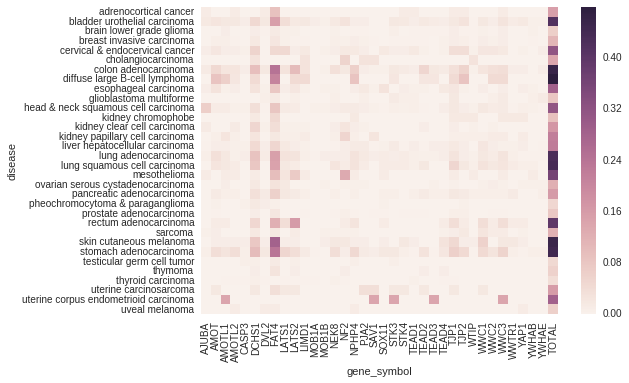

In [16]:
# What is the percentage of different mutations across different cancer types?
sns.heatmap(heatmap_df);

Visualizing the input data here is key. The heterogeneity of the mutations across tissues is apparent for this particular pathway. In comparison with `TP53` mutations, it appears that Hippo signaling impacts different tissues with higher diversity.

Looking closer at the plots above, it is evident that several tissues do not demonstrate aberrations (at least at the mutation level) in Hippo signaling. Specifically, it appears that cancers with gender specificity like testicular cancer and and prostate cancer are _not_ impacted. Therefore, because of this artificial imbalance, if Cognoma were to include these cancers in the classifier, it **will** key in on gender specific signal (i.e. genes that are only on the Y chromosome, or X inactivation genes).  

In [17]:
# How many samples in each tissue that have Hippo signaling aberrations
ind = ['Negatives', 'Positives', 'Positive Prop']
percent = heatmap_df['TOTAL']
neg = y.disease.value_counts() - unique_pos
tissue_summary_df = pd.DataFrame([neg, unique_pos, percent], index=ind, 
                                 dtype='object').T.sort_values('Positive Prop', ascending=False)
tissue_summary_df

,Negatives,Positives,Positive Prop
diffuse large B-cell lymphoma,25,23,0.479167
colon adenocarcinoma,114,96,0.457143
skin cutaneous melanoma,56,47,0.456311
stomach adenocarcinoma,151,121,0.444853
lung squamous cell carcinoma,101,77,0.432584
lung adenocarcinoma,280,207,0.425051
bladder urothelial carcinoma,227,163,0.417949
rectum adenocarcinoma,49,32,0.395062
mesothelioma,53,30,0.361446
cervical & endocervical cancer,132,61,0.316062


## Filter Data by Tissue

This is a crucial step that is different from previous classifiers

In [18]:
# Technically, these are hyper parameters, but for simplicity, set here
filter_prop = 0.10
filter_count = 15

tissue_prop_decision = tissue_summary_df['Positive Prop'] >= filter_prop
tissue_count_decision = tissue_summary_df['Positives'] >= filter_count

tissue_decision = tissue_prop_decision & tissue_count_decision

In [19]:
# This criteria filters out the following tissues
pd.Series(tissue_summary_df.index[~tissue_decision].sort_values())

0                     adrenocortical cancer
1                  brain lower grade glioma
2                        cholangiocarcinoma
3                   glioblastoma multiforme
4                        kidney chromophobe
5          pheochromocytoma & paraganglioma
6                   prostate adenocarcinoma
7                testicular germ cell tumor
8                                   thymoma
9                         thyroid carcinoma
10                   uterine carcinosarcoma
11    uterine corpus endometrioid carcinoma
12                           uveal melanoma
dtype: object

In [20]:
# What are the tissues remaining?
tissue_summary_df = tissue_summary_df[tissue_decision]
tissue_summary_df

,Negatives,Positives,Positive Prop
diffuse large B-cell lymphoma,25,23,0.479167
colon adenocarcinoma,114,96,0.457143
skin cutaneous melanoma,56,47,0.456311
stomach adenocarcinoma,151,121,0.444853
lung squamous cell carcinoma,101,77,0.432584
lung adenocarcinoma,280,207,0.425051
bladder urothelial carcinoma,227,163,0.417949
rectum adenocarcinoma,49,32,0.395062
mesothelioma,53,30,0.361446
cervical & endocervical cancer,132,61,0.316062


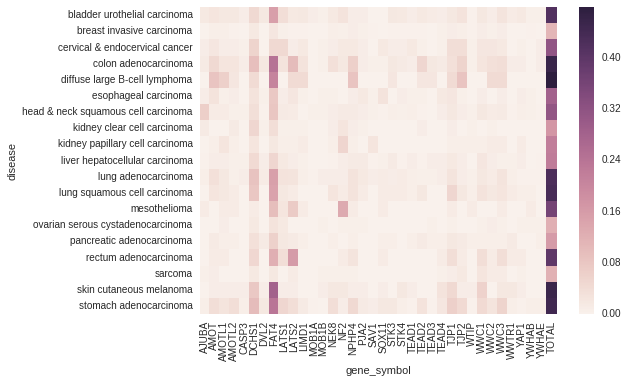

In [21]:
# Distribution of mutation counts after filtering
sns.heatmap(heatmap_df.loc[tissue_decision]);

In [22]:
# Subset data
clinical_sub = clinical[clinical['disease'].isin(tissue_summary_df.index)]
X_sub = X.ix[clinical_sub.index]
y_sub = y['indicator'].ix[clinical_sub.index]

In [23]:
# Total distribution of positives/negatives
y_sub.value_counts(True)

0    0.721539
1    0.278461
Name: indicator, dtype: float64

In [24]:
y_sub.head(7)

sample_id
TCGA-04-1348-01    0
TCGA-04-1357-01    0
TCGA-04-1362-01    0
TCGA-05-4244-01    0
TCGA-05-4249-01    1
TCGA-05-4250-01    0
TCGA-05-4382-01    1
Name: indicator, dtype: int64

## Set aside 10% of the data for testing

In [25]:
strat = clinical_sub['disease'].str.cat(y_sub.astype(str))
strat.head(6)

sample_id
TCGA-04-1348-01    ovarian serous cystadenocarcinoma0
TCGA-04-1357-01    ovarian serous cystadenocarcinoma0
TCGA-04-1362-01    ovarian serous cystadenocarcinoma0
TCGA-05-4244-01                  lung adenocarcinoma0
TCGA-05-4249-01                  lung adenocarcinoma1
TCGA-05-4250-01                  lung adenocarcinoma0
Name: disease, dtype: object

In [26]:
# Make sure the splits have equal tissue and label partitions
X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, test_size=0.1, random_state=0,
                                                    stratify=strat)
'Size: {:,} features, {:,} training samples, {:,} testing samples'.format(len(X_sub.columns),
                                                                          len(X_train), len(X_test))

'Size: 20,530 features, 4,537 training samples, 505 testing samples'

## Median absolute deviation feature selection

In [27]:
def fs_mad(x, y):
    """    
    Get the median absolute deviation (MAD) for each column of x
    """
    scores = mad(x) 
    return scores, np.array([np.NaN]*len(scores))

## Define pipeline and Cross validation model fitting

In [28]:
# Parameter Sweep for Hyperparameters
param_grid = {
    'select__k': [8000],
    'classify__loss': ['log'],
    'classify__penalty': ['elasticnet'],
    'classify__alpha': [10 ** x for x in range(-3, 1)],
    'classify__l1_ratio': [0, 0.2, 0.8, 1],
}

pipeline = Pipeline(steps=[
    ('select', SelectKBest(fs_mad)),
    ('standardize', StandardScaler()),
    ('classify', SGDClassifier(random_state=0, class_weight='balanced'))
])

cv_pipeline = GridSearchCV(estimator=pipeline, param_grid=param_grid, n_jobs=-1, cv=folds, scoring='roc_auc')

In [29]:
%%time
cv_pipeline.fit(X=X_train, y=y_train);

CPU times: user 1min 38s, sys: 984 ms, total: 1min 39s
Wall time: 3min 34s


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('select', SelectKBest(k=10, score_func=<function fs_mad at 0x7fa823d28158>)), ('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classify', SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=0, shuffle=True, verbose=0,
       warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'classify__penalty': ['elasticnet'], 'classify__loss': ['log'], 'classify__alpha': [0.001, 0.01, 0.1, 1], 'classify__l1_ratio': [0, 0.2, 0.8, 1], 'select__k': [8000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [30]:
# Best Params
print('{:.3%}'.format(cv_pipeline.best_score_))

# Best Params
cv_pipeline.best_params_

70.303%


{'classify__alpha': 1,
 'classify__l1_ratio': 0,
 'classify__loss': 'log',
 'classify__penalty': 'elasticnet',
 'select__k': 8000}

## Visualize hyperparameters performance

In [31]:
cv_result_df = pd.concat([
    pd.DataFrame(cv_pipeline.cv_results_),
    pd.DataFrame.from_records(cv_pipeline.cv_results_['params']),
], axis='columns')
cv_result_df.head(2)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_classify__alpha,param_classify__l1_ratio,param_classify__loss,param_classify__penalty,param_select__k,params,...,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score,classify__alpha,classify__l1_ratio,classify__loss,classify__penalty,select__k
0,8.520873,0.275811,0.624556,0.905039,0.001,0,log,elasticnet,8000,"{'classify__penalty': 'elasticnet', 'classify_...",...,0.892810,0.823080,0.052136,0.021455,0.030229,0.001,0.0,log,elasticnet,8000
1,9.694654,0.169643,0.648005,0.926384,0.001,0.2,log,elasticnet,8000,"{'classify__penalty': 'elasticnet', 'classify_...",...,0.959474,0.714793,0.052903,0.016287,0.025594,0.001,0.2,log,elasticnet,8000


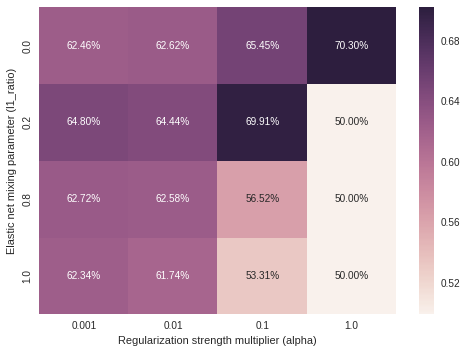

In [32]:
# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(cv_result_df, values='mean_test_score', index='classify__l1_ratio', columns='classify__alpha')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.2%')
ax.set_xlabel('Regularization strength multiplier (alpha)')
ax.set_ylabel('Elastic net mixing parameter (l1_ratio)');

## Use Optimal Hyperparameters to Output ROC Curve

In [33]:
y_pred_train = cv_pipeline.decision_function(X_train)
y_pred_test = cv_pipeline.decision_function(X_test)

def get_threshold_metrics(y_true, y_pred, tissue='all'):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df, 'tissue': tissue}

metrics_train = get_threshold_metrics(y_train, y_pred_train)
metrics_test = get_threshold_metrics(y_test, y_pred_test)

In [34]:
# Rerun "cross validation" for the best hyperparameter set to define
# cross-validation disease-specific performance. Each sample prediction is
# based on the fold that the sample was in the testing partition
y_cv = cross_val_predict(cv_pipeline.best_estimator_, X=X_train, y=y_train,
                         cv=folds, method='decision_function')
metrics_cv = get_threshold_metrics(y_train, y_cv)

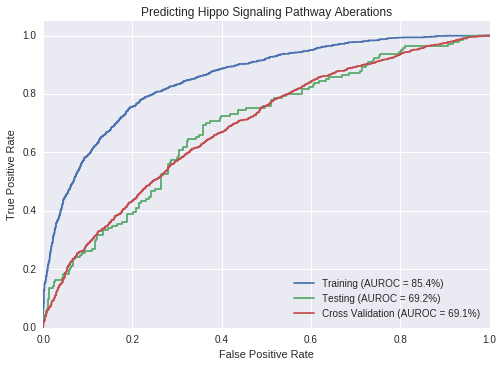

In [35]:
# Plot ROC
plt.figure()
for label, metrics in ('Training', metrics_train), ('Testing', metrics_test), ('Cross Validation', metrics_cv):
    roc_df = metrics['roc_df']
    plt.plot(roc_df.fpr, roc_df.tpr,
        label='{} (AUROC = {:.1%})'.format(label, metrics['auroc']))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predicting Hippo Signaling Pathway Aberations')
plt.legend(loc='lower right');

## Tissue specific performance

In [36]:
tissue_metrics = {}
for tissue in clinical_sub.disease.unique():
    sample_sub = clinical_sub[clinical_sub['disease'] == tissue].index.values

    y_tissue_train = y_train[y_train.index.isin(sample_sub)]
    y_tissue_pred_train = y_pred_train[y_train.index.isin(sample_sub)]
    y_tissue_test = y_test[y_test.index.isin(sample_sub)]
    y_tissue_pred_test = y_pred_test[y_test.index.isin(sample_sub)]
    y_tissue_pred_cv = y_cv[y_train.index.isin(sample_sub)]

    metrics_train = get_threshold_metrics(y_tissue_train, y_tissue_pred_train, tissue=tissue)
    metrics_test = get_threshold_metrics(y_tissue_test, y_tissue_pred_test, tissue=tissue) 
    metrics_cv_tis = get_threshold_metrics(y_tissue_train, y_tissue_pred_cv, tissue=tissue)
    tissue_metrics[tissue] = [metrics_train, metrics_test, metrics_cv_tis]

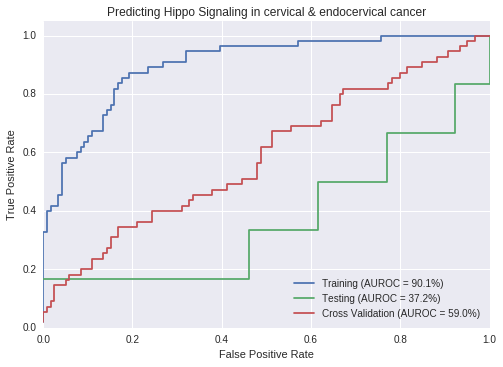

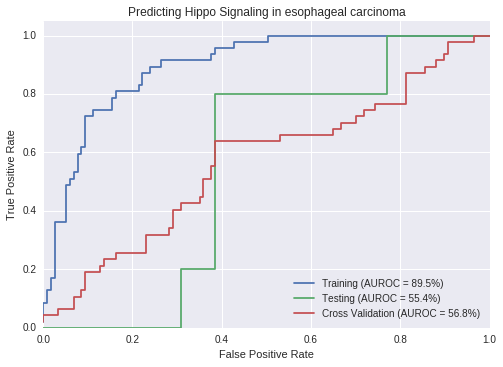

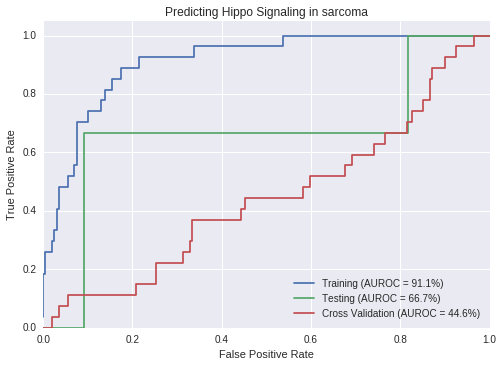

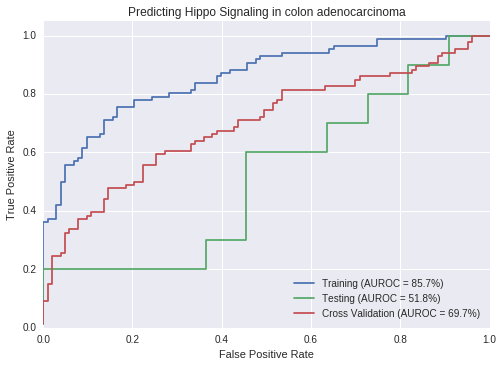

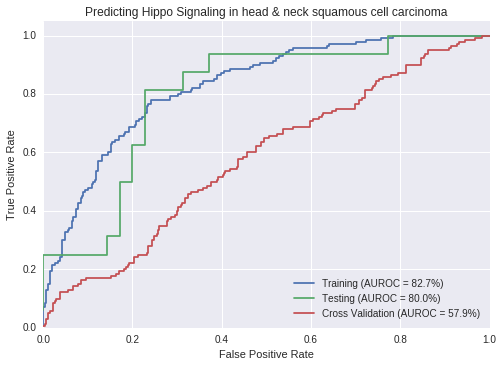

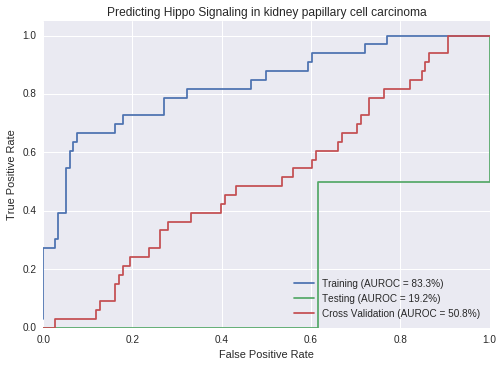

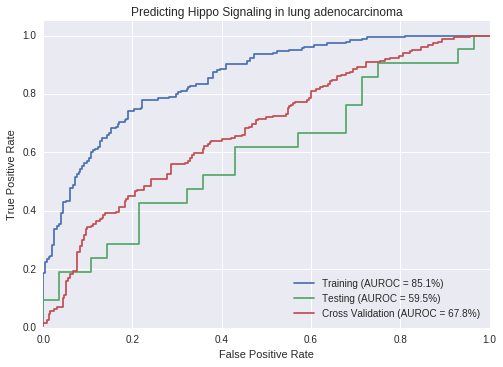

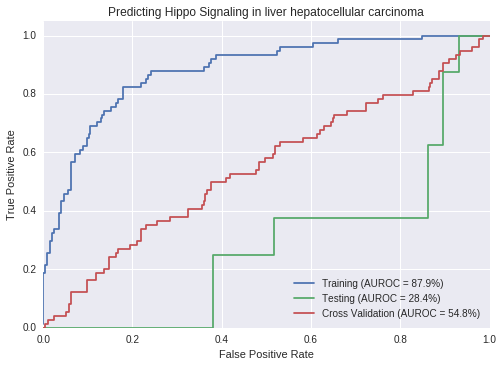

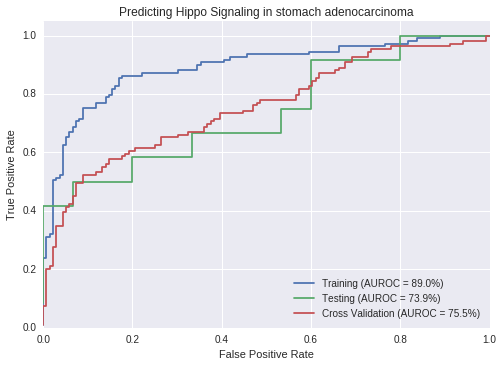

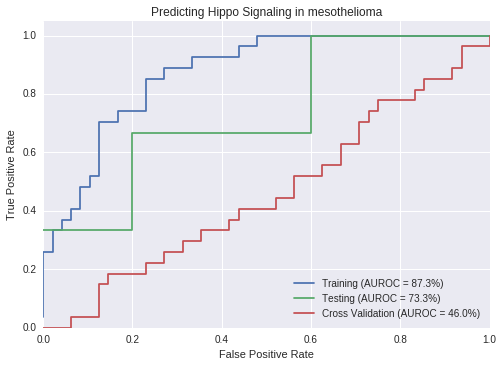

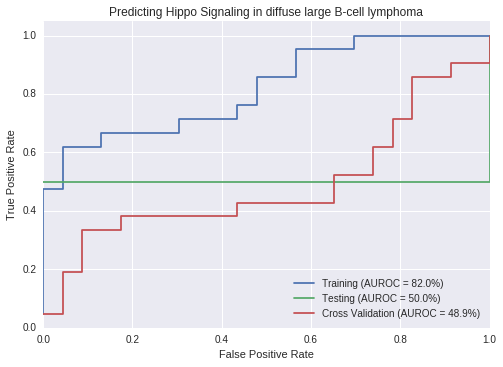

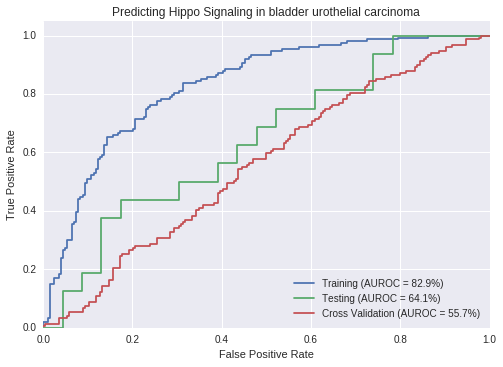

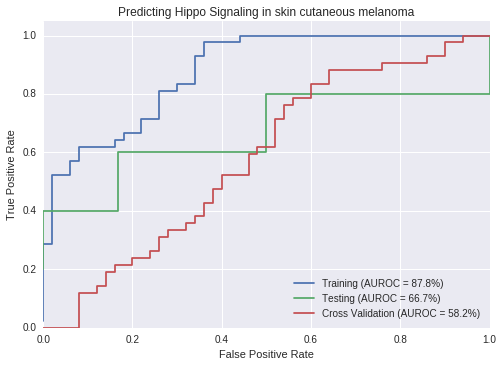

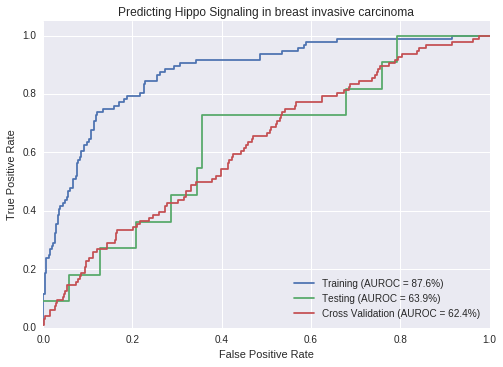

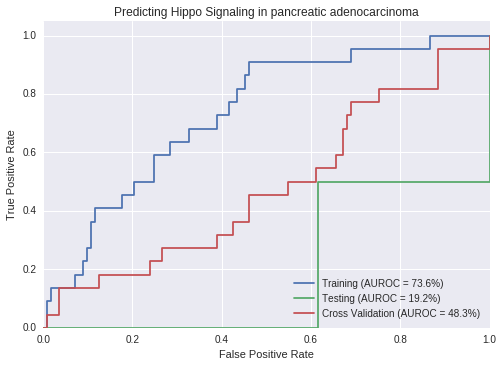

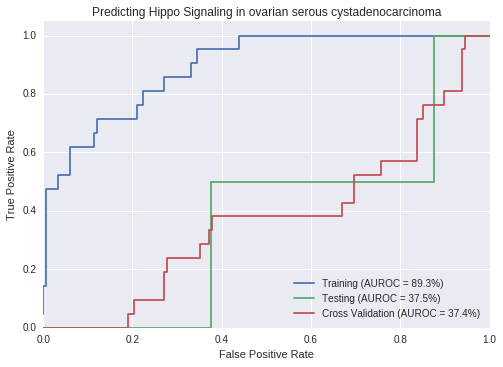

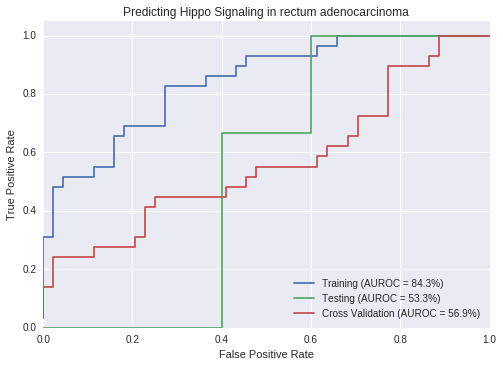

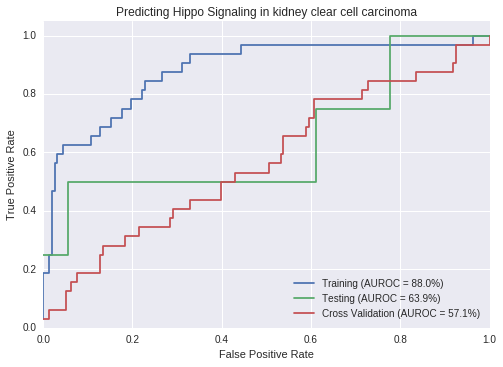

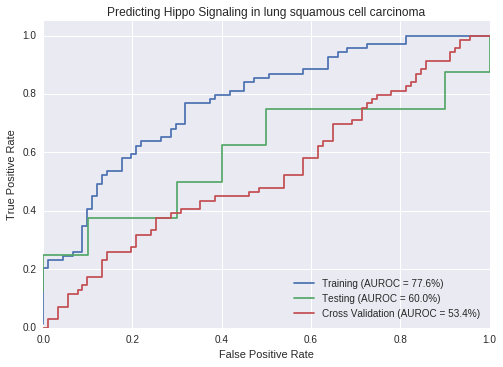

In [37]:
tissue_auroc = {}
plt.figure()
for tissue, metrics_val in tissue_metrics.items():
    metrics_train, metrics_test, met_cv = metrics_val
    plt.subplot()
    auroc = []
    for label, metrics in ('Training', metrics_train), ('Testing', metrics_test), ('Cross Validation', met_cv):
        roc_df = metrics['roc_df']
        auroc.append(metrics['auroc'])
        plt.plot(roc_df.fpr, roc_df.tpr,
            label='{} (AUROC = {:.1%})'.format(label, metrics['auroc']))
    tissue_auroc[tissue] = auroc
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Predicting Hippo Signaling in {}'.format(tissue))
    plt.legend(loc='lower right'); 
    plt.show()

In [38]:
tissue_results = pd.DataFrame(tissue_auroc, index=['Train', 'Test', 'Cross Validation']).T
tissue_results = tissue_results.sort_values('Cross Validation', ascending=False)

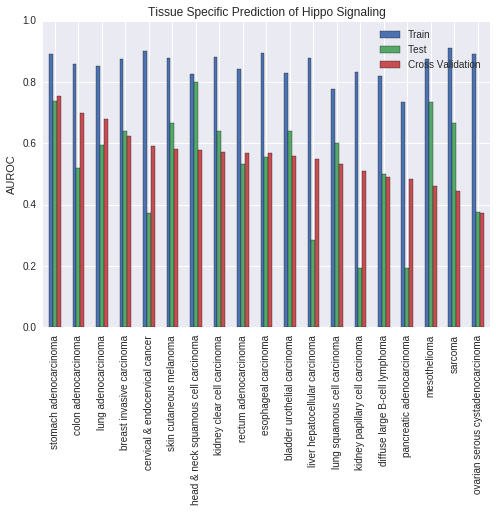

In [39]:
ax = tissue_results.plot(kind='bar', title='Tissue Specific Prediction of Hippo Signaling')
ax.set_ylabel('AUROC');

Hippo signaling prediction has highly variable predictions across different tissues. The classifier performs spectacularly in several tissues, but also appears to oppositely predict Hippo signaling in others. In three tissues the `test` set performance is actually _greater_ than the `train` set performance. This is likely a result of variance in samples across tissues and a happenstance in stratified `train_test_split`.

## What are the classifier coefficients?

In [40]:
final_pipeline = cv_pipeline.best_estimator_
final_classifier = final_pipeline.named_steps['classify']

In [41]:
select_indices = final_pipeline.named_steps['select'].transform(
    np.arange(len(X.columns)).reshape(1, -1)
).tolist()

coef_df = pd.DataFrame.from_items([
    ('feature', X.columns[select_indices]),
    ('weight', final_classifier.coef_[0]),
])

coef_df['abs'] = coef_df['weight'].abs()
coef_df = coef_df.sort_values('abs', ascending=False)

In [42]:
'{:.1%} zero coefficients; {:,} negative and {:,} positive coefficients'.format(
    (coef_df.weight == 0).mean(),
    (coef_df.weight < 0).sum(),
    (coef_df.weight > 0).sum()
)

'0.0% zero coefficients; 4,088 negative and 3,912 positive coefficients'

In [43]:
coef_df.head(10)

,feature,weight,abs
7392,387628,0.018765,0.018765
7470,389458,0.017407,0.017407
1592,4438,0.016207,0.016207
7511,399671,-0.015239,0.015239
3488,22943,-0.014762,0.014762
7496,391322,0.014552,0.014552
1895,5457,0.014285,0.014285
5718,93426,-0.014180,0.014180
6815,246777,-0.014153,0.014153
104,290,-0.014139,0.014139


The results are very interesting. First, only 200 genes are used to build a fairly successful classifier. Biologists like sparsity! Second, the genes that fall out at the top are informative:

| Entrez | Symbol | Comments |
| ------ | ---- | -------- |
| 399671 | [HEATR4](http://www.ncbi.nlm.nih.gov/gene/399671) | Relatively unstudied gene |
| 29126 | [CD274](http://www.ncbi.nlm.nih.gov/gene/29126) | Immune cell receptor - inhibits Tcell activation and cytokine production |
| 2852 | [GPER1](http://www.ncbi.nlm.nih.gov/gene/2852) | Estrogen receptor - implicated in lymphoma |
| 140730 | [RIMS4](http://www.ncbi.nlm.nih.gov/gene/140730) | Synaptic regulatory protein |
| 84688 | [C9orf24](http://www.ncbi.nlm.nih.gov/gene/84688) | relatively unknown gene - important for differentiation of bronchial cells |
| 387628 | [FGF7P6](http://www.ncbi.nlm.nih.gov/gene/387628) | Fibroblast growth factor - implicated in ovarian cancer |
| 4438 | [MSH4](http://www.ncbi.nlm.nih.gov/gene/4438) | Involved in DNA mismatch repair |
| 80350 | [LPAL2](http://www.ncbi.nlm.nih.gov/gene/157777) | Pseudogene involved with elevated risk for atherosclerosis |
| 56892 | [C8orf4](http://www.ncbi.nlm.nih.gov/gene/56892) | Relatively uknown gene product - evidence it is important in WNT signaling and proliferation across cancer types |
| 22943 | [DKK1](http://www.ncbi.nlm.nih.gov/gene/22943) | Inhibits WNT signaling pathway - implicated in myeloma |



## Investigate the predictions

In [44]:
predict_df = pd.DataFrame.from_items([
    ('sample_id', X_sub.index),
    ('testing', X_sub.index.isin(X_test.index).astype(int)),
    ('status', y_sub),
    ('decision_function', cv_pipeline.decision_function(X_sub)),
    ('probability', cv_pipeline.predict_proba(X_sub)[:, 1]),
])
predict_df['probability_str'] = predict_df['probability'].apply('{:.1%}'.format)

In [45]:
# Top predictions amongst negatives (potential hidden responders)
predict_df.sort_values('decision_function', ascending=False).query("status == 0").head(10)

,sample_id,testing,status,decision_function,probability,probability_str
sample_id,,,,,,
TCGA-FJ-A3ZF-01,TCGA-FJ-A3ZF-01,0,0,1.727619,0.849108,84.9%
TCGA-GU-A42P-01,TCGA-GU-A42P-01,0,0,1.674815,0.842217,84.2%
TCGA-CU-A3QU-01,TCGA-CU-A3QU-01,0,0,1.640265,0.837571,83.8%
TCGA-64-5779-01,TCGA-64-5779-01,1,0,1.606633,0.832943,83.3%
TCGA-BR-7707-01,TCGA-BR-7707-01,0,0,1.576964,0.828774,82.9%
TCGA-HQ-A2OE-01,TCGA-HQ-A2OE-01,1,0,1.564581,0.827010,82.7%
TCGA-FR-A3R1-01,TCGA-FR-A3R1-01,0,0,1.559338,0.826258,82.6%
TCGA-FS-A1ZN-01,TCGA-FS-A1ZN-01,1,0,1.425229,0.806157,80.6%
TCGA-CM-6675-01,TCGA-CM-6675-01,0,0,1.377644,0.798612,79.9%


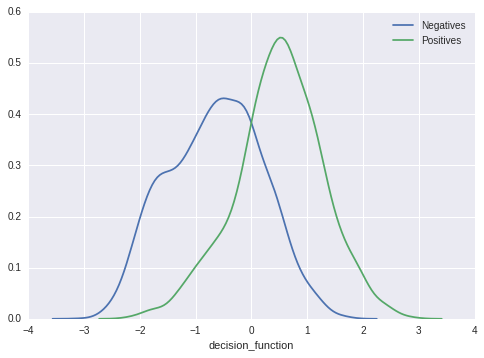

In [46]:
# Ignore numpy warning caused by seaborn
warnings.filterwarnings('ignore', 'using a non-integer number instead of an integer')

ax = sns.distplot(predict_df.query("status == 0").decision_function, hist=False, label='Negatives')
ax = sns.distplot(predict_df.query("status == 1").decision_function, hist=False, label='Positives')

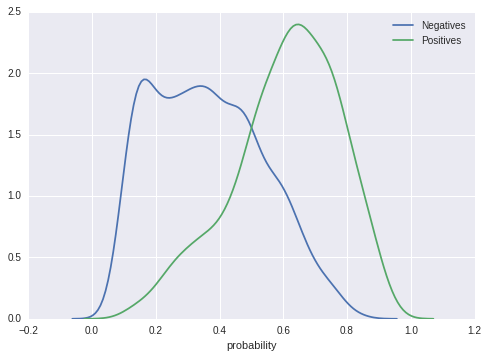

In [47]:
ax = sns.distplot(predict_df.query("status == 0").probability, hist=False, label='Negatives')
ax = sns.distplot(predict_df.query("status == 1").probability, hist=False, label='Positives')